# Lecture 15: Practical Intro to IBM Qiskit

In [1]:
# Import usual python numerical library
import numpy as np
# Importing standard Qiskit libraries
from qiskit import *
%matplotlib inline

In [ ]:
import subprocess

#this is so I can run the code on my computer without sharing my token online
#you can get your own token at https://quantum-computing.ibm.com/account
token = subprocess.run("echo $IBM_TOKEN", shell=True, stdout=subprocess.PIPE).stdout.decode('utf-8').strip()


b471be84ff8eccbcf9058ca06dcdd1320b11371d4e65d3e4df5d901f77e7023d2185650f2f1b7d9061cf6a4c7d7828cec469d686f4e6d53758c5248e9e760a61


In [3]:
# Insert your token
from qiskit_ibm_runtime import QiskitRuntimeService
 
QiskitRuntimeService.save_account(
  token=token,
  channel="ibm_quantum", # `channel` distinguishes between different account types
  overwrite=True, set_as_default=True)

In [4]:
# List the backends available to you. 
service = QiskitRuntimeService(channel="ibm_quantum")
service.backends()

[<IBMBackend('ibm_brisbane')>,
 <IBMBackend('ibm_kyiv')>,
 <IBMBackend('ibm_sherbrooke')>]

In [5]:
from qiskit_aer import AerSimulator

In [6]:
# This sets a simulator and a real device for you to work with. Feel free to choose a different real device by 
# checking if it's less busy.
backend_simulator = AerSimulator()
backend_brisbane = service.backend("ibm_brisbane")

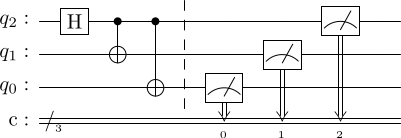

In [7]:
# Now let's construct a circuit
# Define circuit with 3 qubits, 3 cbits
circ = QuantumCircuit(3, 3)
# Apply Hadamard on qubit 2
circ.h(2)
# Apply cnot_{2,1}
circ.cx(2, 1)
# Apply cnot_{2,0}
circ.cx(2, 0)
# This adds a barrier to separate the qubit readout from the gates, makes visualization easier
circ.barrier(range(3))
# Now adding the qubit readouts
circ.measure(range(3),range(3))
# This is going to draw the circuit. IBM takes the convention that the lowest significant qubit is at the top; I can't get my mind around this :-). 
# So I tell IBM to reverse the orders of the qubits when printing the circuit. That way the notation becomes consistent with our convention.  
circ.draw(reverse_bits=True, output="latex")

In [8]:
# Now let's start running some jobs. First, let's play with the simulator. Remember, it can only handle a small circuit (about 20 qubits). 
# The command below will run the circuit in the simulator 1000 times. 
job_simulator = backend_simulator.run(circ, shots=1000)

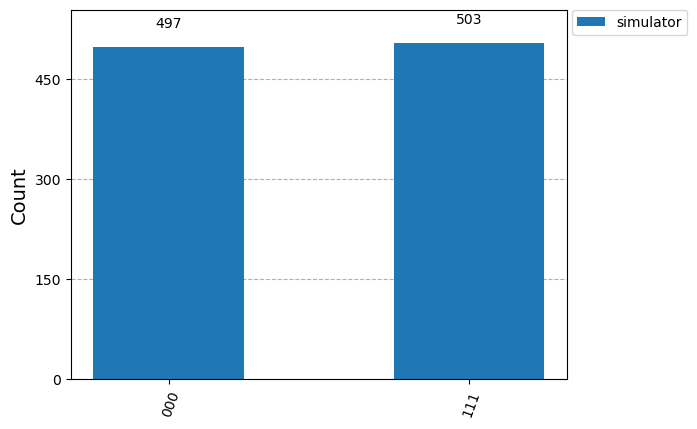

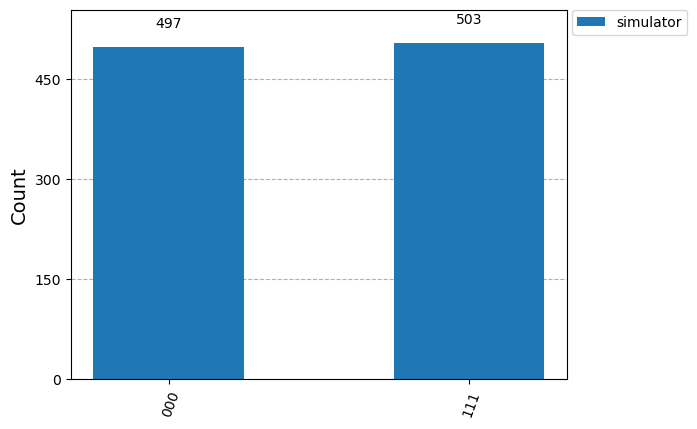

In [9]:
# Let's visualize the output. This plots the histogram of readouts.
from qiskit.visualization import *
result_simulator = job_simulator.result()
counts_simulator = result_simulator.get_counts(circ)
plot_histogram([counts_simulator], legend=['simulator'])

# IMPORTANT: The notation in the x axis shows the most significan cbit in the bottom, the least significant is at the top. 

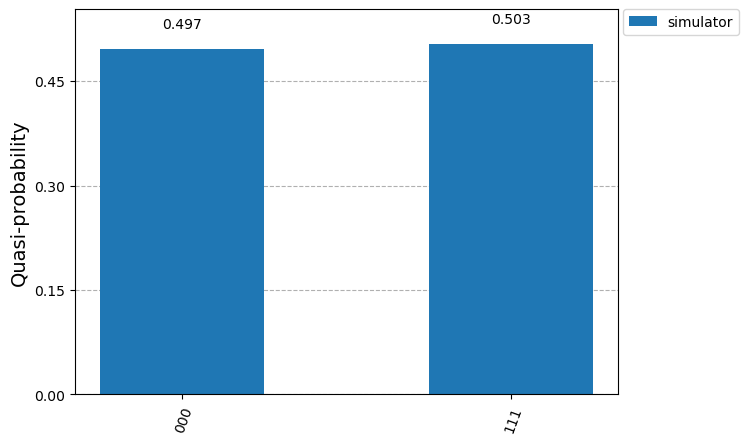

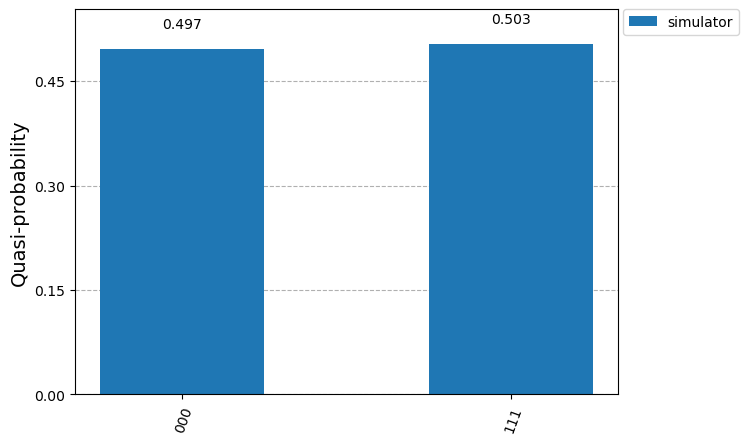

In [10]:
# The histogram has counts, and it's convenient to convert them to an estimate of the probabilities of measurement. 
# These are called quasi-probabilities because they get accurate only when the number of shots is large. For 1000
# shots, you see that they deviate a little bit from the expected value of 0.5.
plot_distribution([counts_simulator], legend=['simulator'])

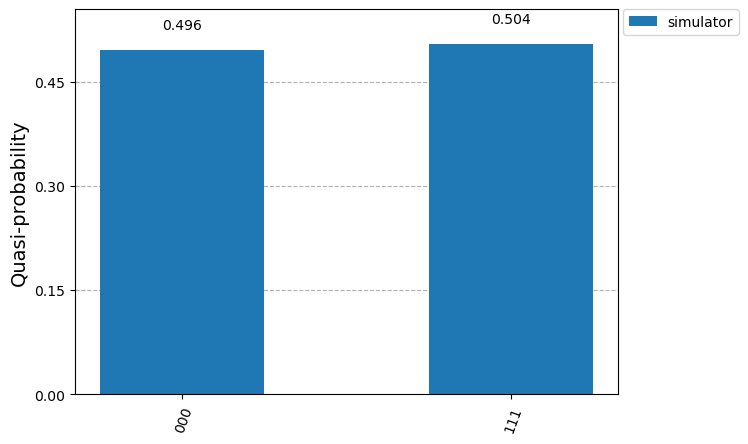

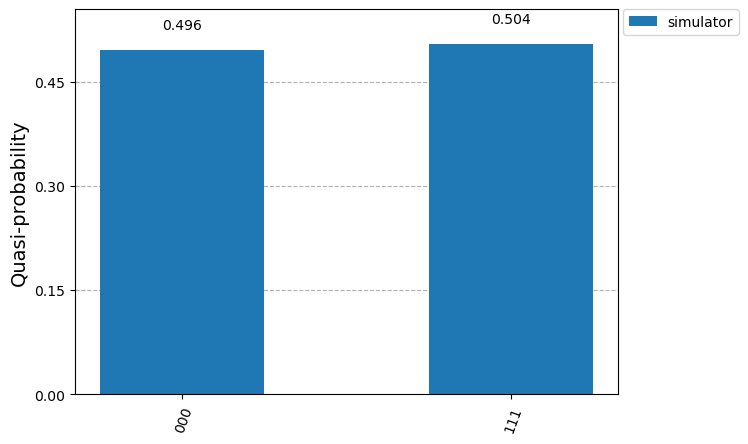

In [11]:
# Let's increase the number of shots to see if we get closer to 0.5
job_simulator = backend_simulator.run(circ, shots=10000)
result_simulator = job_simulator.result()
counts_simulator = result_simulator.get_counts(circ)
plot_distribution([counts_simulator], legend=['simulator'])

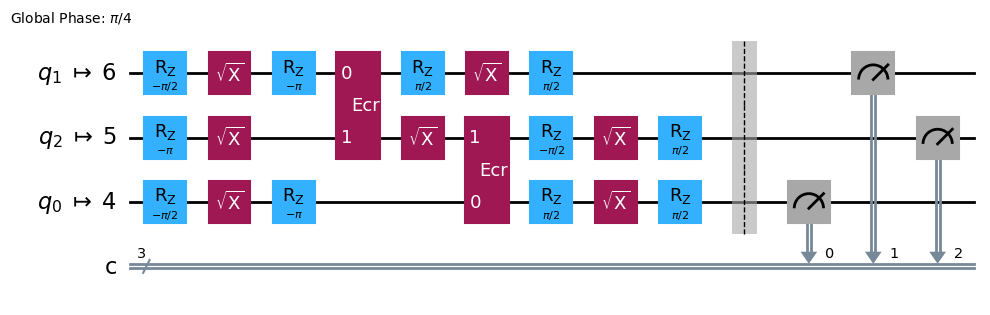

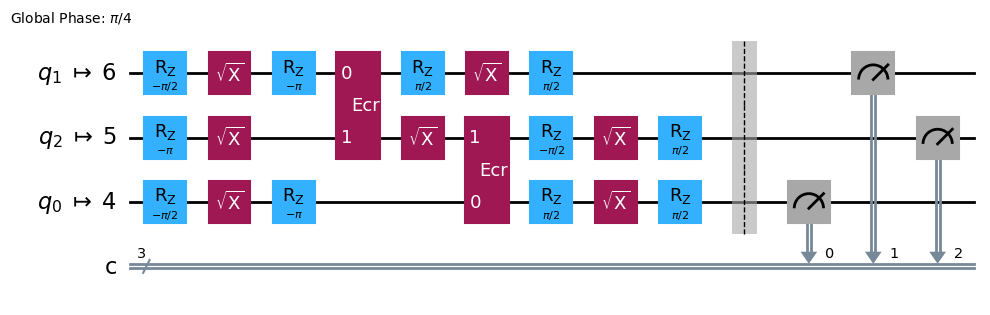

In [12]:
# Submit job to real device -- Need to first transpile the circuit "circ" in order to convert it 
# to gates that are native to the particular hardware. This creates a circuit that adheres to the "instruction set architecture"= ISA.
# The option idle_wires=False tells qiskit 
# to not draw the wires/qubits that are not being used. 
# The first line creates the python object called "primitive" that compiles the new isa_cir. 
pm = generate_preset_pass_manager(backend=backend_brisbane, optimization_level=1)
isa_circ = pm.run(circ)
isa_circ.draw(reverse_bits=True, idle_wires=False, output="mpl")

In [13]:
# Submit job to real device (brisbane)
from qiskit_ibm_runtime import SamplerV2
sampler = SamplerV2(backend_brisbane)
job_brisbane1 = sampler.run([isa_circ])

In [14]:
# Keep the plots below in case hardware takes too long to run

In [15]:
counts_brisbane1 = job_brisbane1.result()[0].data.c.get_counts()
print(counts_brisbane1)

{'101': 50, '000': 2008, '111': 1880, '110': 59, '011': 12, '001': 42, '010': 40, '100': 5}


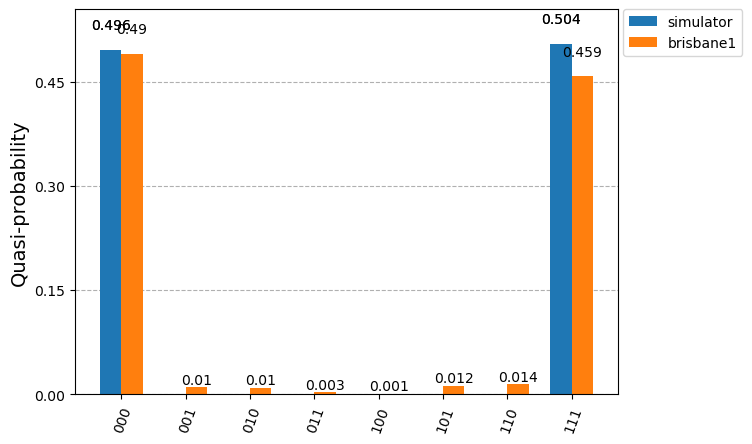

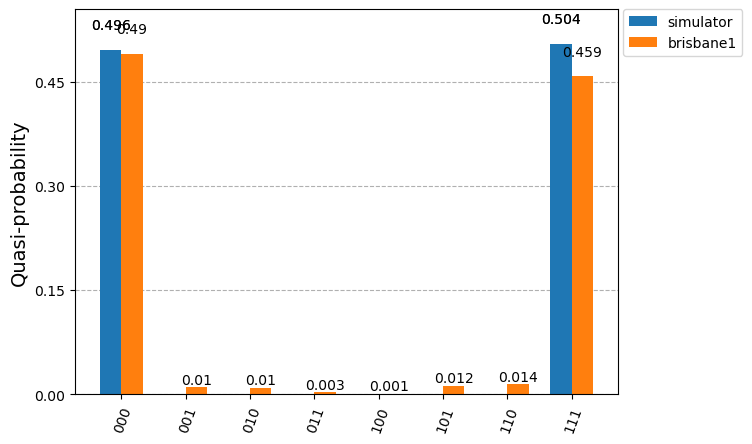

In [16]:
# Let's plot the simulation together with our real device run to compare
plot_distribution([counts_simulator, counts_brisbane1], legend = ['simulator', 'brisbane1'] )